In [1]:
load_or_install <- function(pkg) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

packages <- c("forecast", "ggplot2", "Metrics", "grid", "extrafont")
invisible(lapply(packages, load_or_install))

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: ggplot2

Loading required package: Metrics


Attaching package: 'Metrics'


The following object is masked from 'package:forecast':

    accuracy


Loading required package: grid

Loading required package: extrafont

Registering fonts with R



In [2]:
library(showtext)

font_add(
  family = "TH Sarabun New",
  regular = "C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/THSarabunNew.ttf",
  bold    = "C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/THSarabunNew Bold.ttf"
)

showtext_auto()

showtext_auto()


Loading required package: sysfonts

Loading required package: showtextdb


Attaching package: 'showtextdb'


The following object is masked from 'package:extrafont':

    font_install




In [3]:
options(repr.plot.width = 25, repr.plot.height =10)

In [4]:
data <- read.csv("C:/Users/User/Desktop/Xau nolag.csv")
data$Date <- as.Date(data$Date, format = "%m/%d/%Y")
data <- data[order(data$Date), ]

In [5]:
n <- nrow(data)
n_train <- floor(0.8 * n)
train_data <- data[1:n_train, ]
test_data  <- data[(n_train + 1):n, ]

In [6]:
train_ts <- ts(train_data$Y)

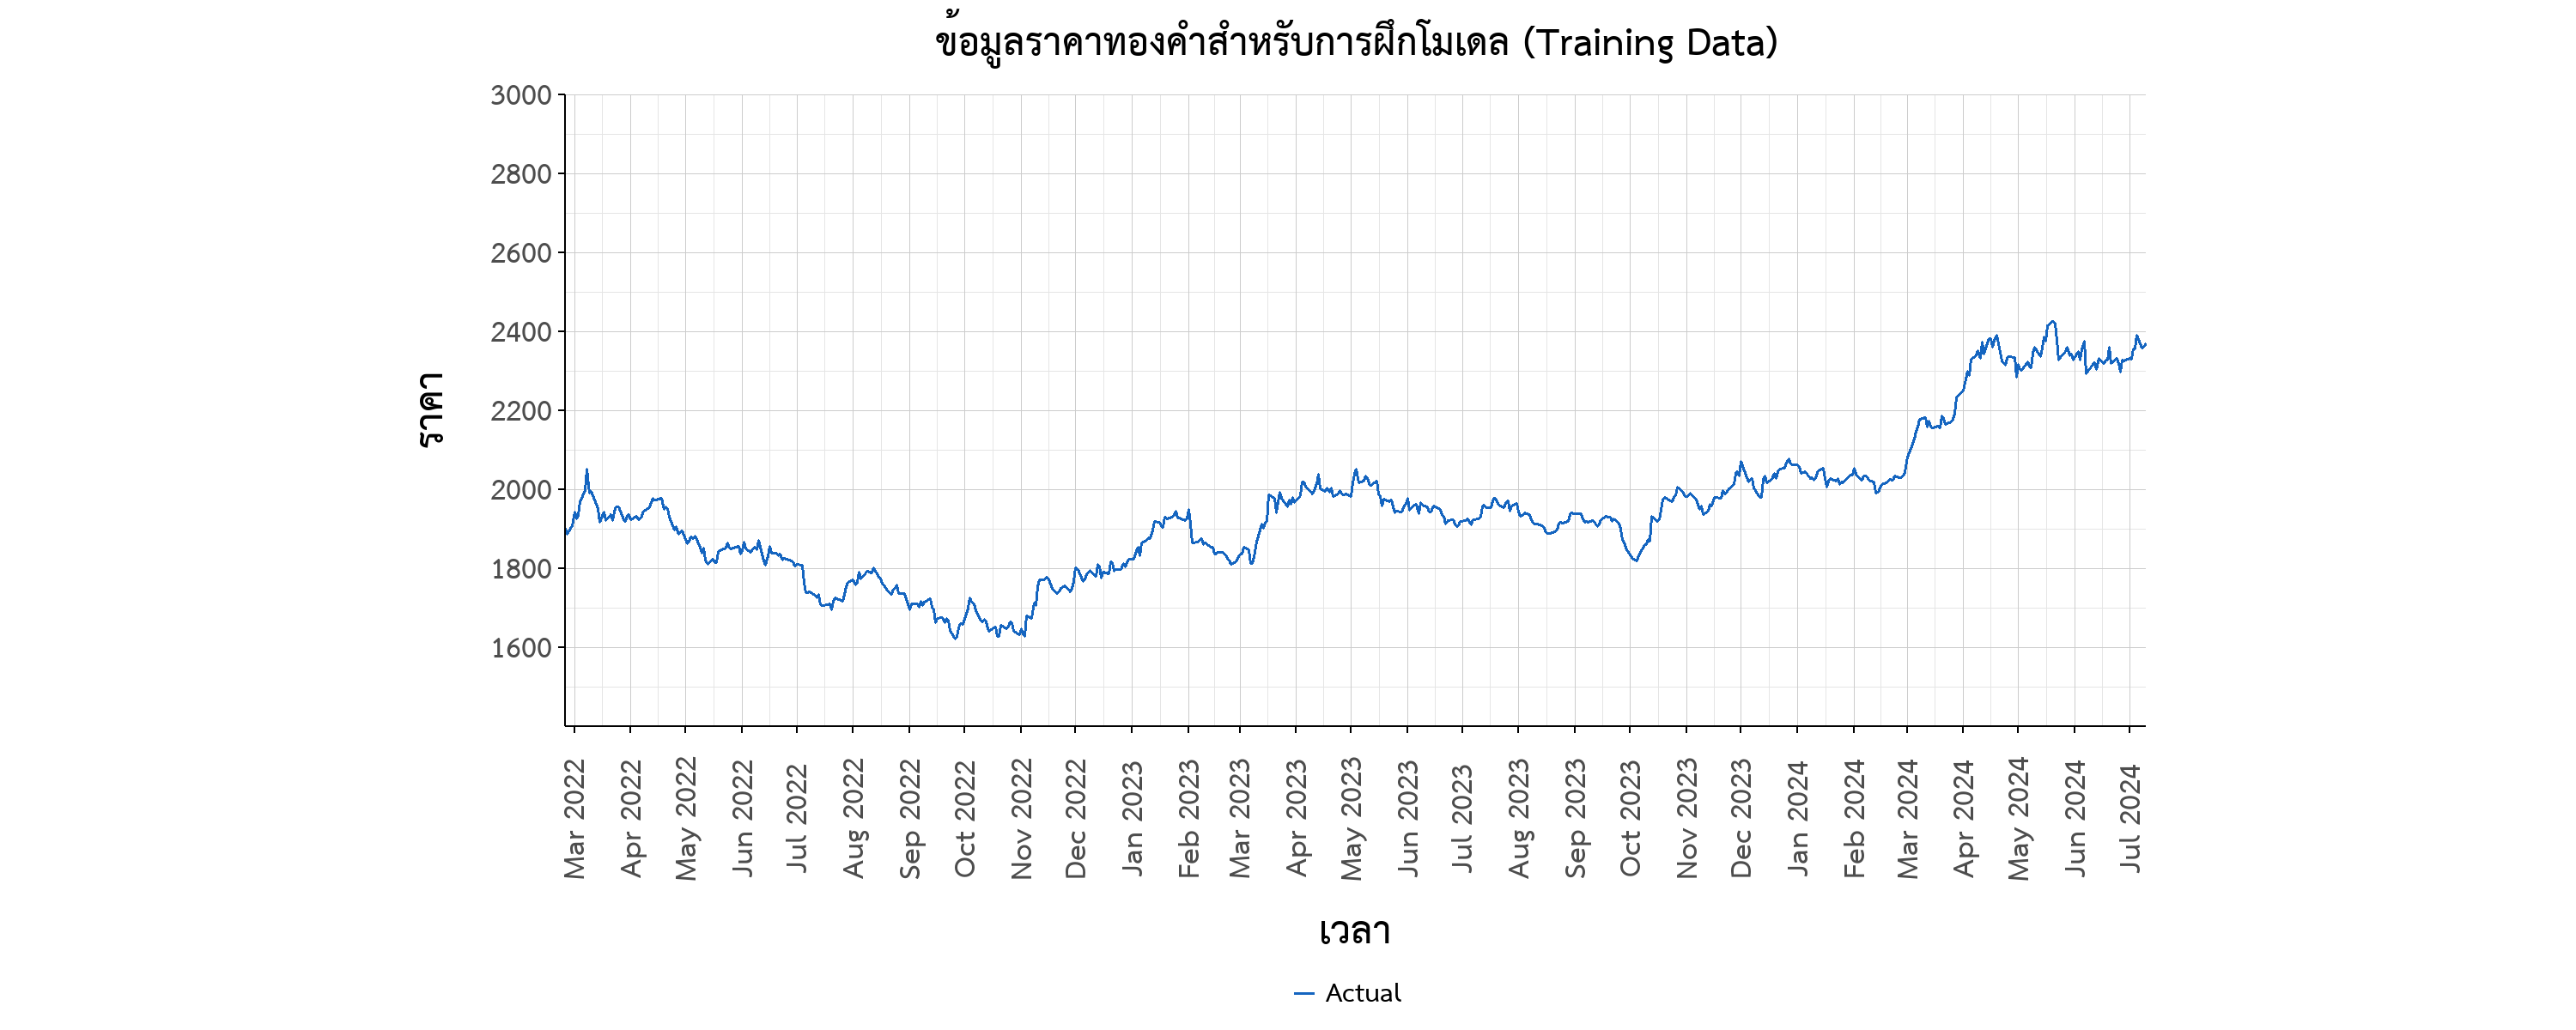

In [7]:
plot_train <- data.frame(
  Date = train_data$Date, 
  Actual = as.numeric(train_ts)
)
p0 <- ggplot(plot_train, aes(x = Date, y = Actual)) +
  geom_line(aes(color = "Actual", linetype = "Actual", group = 1), linewidth = 1) +
  scale_color_manual(
    name   = NULL,
    values = c("Actual" = "#1565c0")
  ) +
  scale_linetype_manual(
    name   = NULL,
    values = c("Actual" = "solid")
  ) +
  scale_x_date(
    date_breaks = "1 month", 
    date_labels = "%b %Y",
    expand = expansion(add = c(0, 0.03))
  ) +
  scale_y_continuous(
    limits = c(1400, 3000),
    breaks = seq(1600, 3200, 200),
    expand = expansion(add = c(0, 0))
  ) +
  labs(
    title = "ข้อมูลราคาทองคำสำหรับการฝึกโมเดล (Training Data)",
    x = "เวลา", y = "ราคา"
  ) +
  
  theme_minimal(base_family = "TH Sarabun New") +
  theme(
    plot.margin  = margin(t = 20, r = 20, b = 10, l = 10),
    plot.title   = element_text(hjust = 0.5, size = 48, face = "bold", margin = margin(b = 20)),
    axis.title.x = element_text(size = 48, face = "bold", margin = margin(t = 14)),
    axis.title.y = element_text(size = 48, face = "bold", margin = margin(r = 14)),
    axis.text.x  = element_text(size = 36, face = "bold", angle = 90, vjust = 0.5),
    axis.text.y  = element_text(size = 36, face = "bold"),
    axis.ticks   = element_line(color = "black", linewidth = 0.6),
    axis.ticks.length = unit(5, "pt"),
    axis.line    = element_line(color = "black", linewidth = 0.8),
    legend.position = "bottom",
    legend.text  = element_text(size = 32, face = "bold"),
    panel.grid.major = element_line(color = "grey80", linewidth = 0.5),
    panel.grid.minor = element_line(color = "grey90", linewidth = 0.25),
    aspect.ratio = 0.4
  )

print(p0)

จากข้อมูล ซึ่งเป็นข้อมูลรายวัน (เก็บตามวันที่จริง) พบว่ามีแนวโน้มและไม่มีฤดูกาล จึงมีความเหมาะสมในการพยากรณ์ด้วยวิธีของ Holt

In [8]:
model_holt <- holt(train_ts, h = nrow(test_data))

In [12]:
model_holt$model

Holt's method 

Call:
holt(y = train_ts, h = nrow(test_data))

  Smoothing parameters:
    alpha = 0.9343 
    beta  = 1e-04 

  Initial states:
    l = 1892.2969 
    b = 0.804 

  sigma:  17.7777

     AIC     AICc      BIC 
7534.699 7534.797 7556.832 

เขียนสมการพยากรณ์ราคาทองคำที่ได้จากวิธีของ Holt ได้ดังนี้

The forecasting equation for gold prices obtained from Holt’s method can be written as follo

$$
\hat{Z}_{t+\ell} = 2370.6225 + 0.8034\ell
$$


In [9]:
full_df <- data.frame(
  Date = data$Date,
  Actual = data$Y,
  Fitted = c(as.numeric(model_holt$fitted), rep(NA, nrow(test_data))),
  Forecast = c(rep(NA, nrow(train_data)), as.numeric(model_holt$mean))
)


full_df$Prediction <- ifelse(
  is.na(full_df$Fitted),
  full_df$Forecast,
  full_df$Fitted
)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


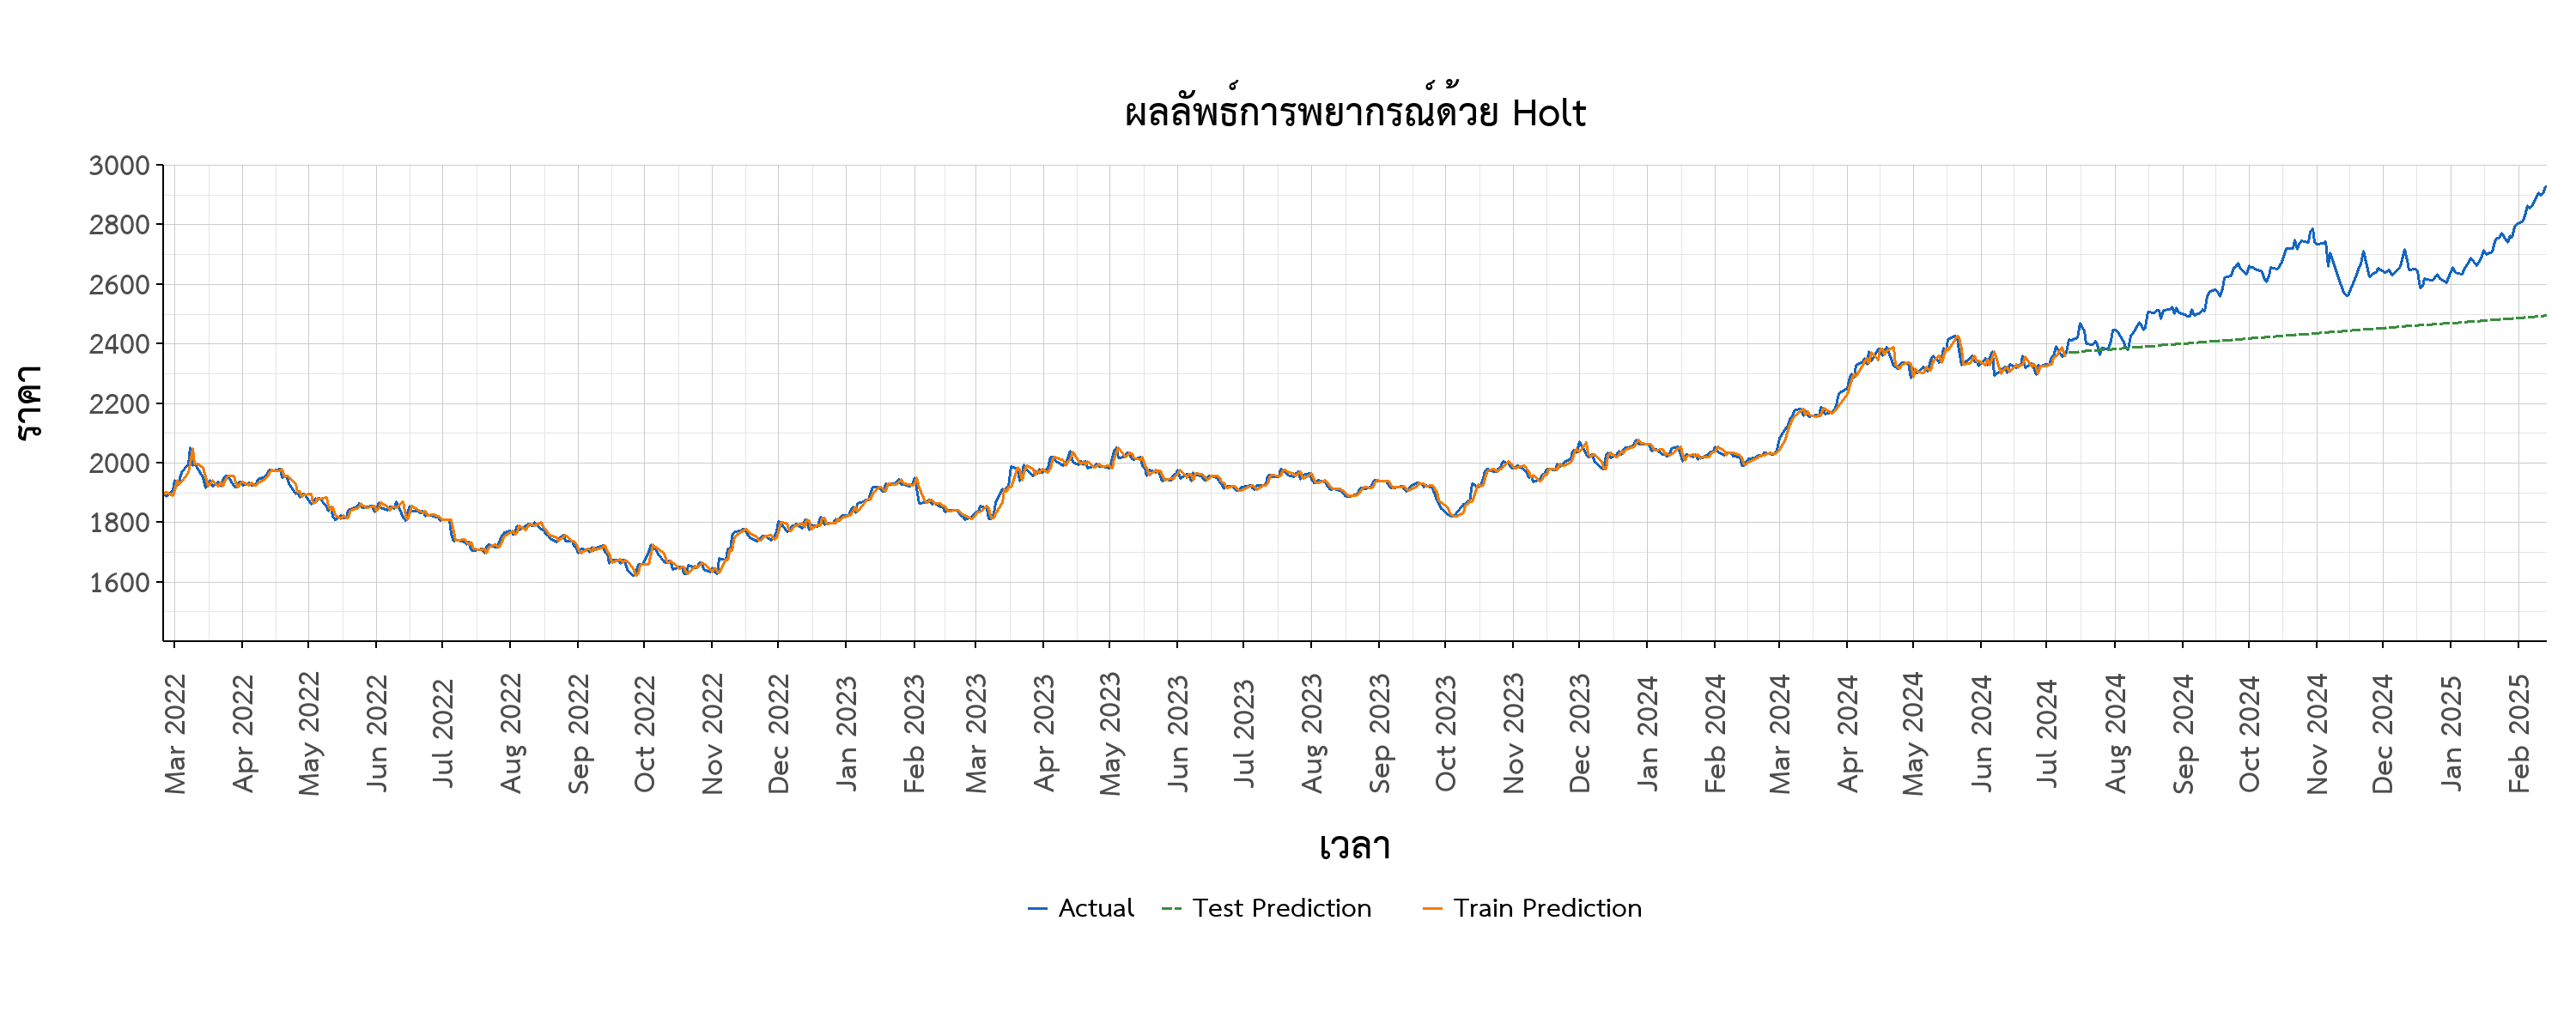

In [10]:
full_df$Train_Pred <- ifelse(!is.na(full_df$Fitted), full_df$Fitted, NA)
full_df$Test_Pred <- ifelse(!is.na(full_df$Forecast), full_df$Forecast, NA)

p <- ggplot(full_df, aes(x = Date)) +
  geom_line(aes(y = Actual,     color = "Actual",           linetype = "Actual",           group = 1), size = 1) +
  geom_line(aes(y = Train_Pred, color = "Train Prediction", linetype = "Train Prediction", group = 1), size = 1, na.rm = TRUE) +
  geom_line(aes(y = Test_Pred,  color = "Test Prediction",  linetype = "Test Prediction",  group = 1), size = 1, na.rm = TRUE) +
  
  scale_color_manual(
    name   = NULL,
    values = c("Actual" = "#1565c0",
               "Train Prediction" = "#f57c00",
               "Test Prediction"  = "#388e3c")
  ) +
  scale_linetype_manual(
    name   = NULL, 
    values = c("Actual" = "solid",
               "Train Prediction" = "solid",
               "Test Prediction"  = "41")
  ) +
  
  scale_x_date(
    date_breaks = "1 month", 
    date_labels = "%b %Y",
    expand = expansion(add = c(0, 0.03))
  ) +
  scale_y_continuous(
    limits = c(1400, 3000),
    breaks = seq(1600, 3200, 200),
    expand = expansion(add = c(0, 0))
  ) +
  
  labs(
    title = "ผลลัพธ์การพยากรณ์ด้วย Holt",
    x = "เวลา", y = "ราคา"
  ) +
  theme_minimal(base_family = "TH Sarabun New") +
  theme(
          plot.title   = element_text(hjust = 0.5, size = 48, face = "bold", margin = margin(b = 20)),
          axis.title.x = element_text(size = 48, face = "bold", margin = margin(t = 14)),
          axis.title.y = element_text(size = 48, face = "bold", margin = margin(r = 14)),
          axis.text.x  = element_text(size = 36, face = "bold", angle = 90, vjust = 0.5),
          axis.text.y  = element_text(size = 36, face = "bold"),
          axis.ticks   = element_line(color = "black", linewidth = 0.6),
          axis.ticks.length = unit(5, "pt"),
          axis.line    = element_line(color = "black", linewidth = 0.8),
          plot.margin  = margin(10,20,10,10),
          legend.position = "bottom",
          legend.text  = element_text(size = 32, face = "bold"),
          panel.grid.major = element_line(color = "grey80", linewidth = 0.5),
          panel.grid.minor = element_line(color = "grey90", linewidth = 0.25),
        
          aspect.ratio = 0.2
      
  )

print(p)


In [11]:

# ดึงค่าที่แท้จริงและค่าที่พยากรณ์เฉพาะช่วง test
actual_test <- test_data$Y
predicted_test <- tail(full_df$Prediction, nrow(test_data))

# คำนวณ RMSE
rmse_test <- rmse(actual_test, predicted_test)

# คำนวณ MAD (Mean Absolute Deviation)
mad_test <- mean(abs(actual_test - predicted_test), na.rm = TRUE)

# คำนวณ MAPE (%)
mape_test <- mean(abs((actual_test - predicted_test) / actual_test), na.rm = TRUE) * 100

# แสดงผล
cat("\n RMSE (Test Set):", round(rmse_test, 4), "USD")
cat("\n MAD  (Test Set):", round(mad_test, 4), "USD")
cat("\n MAPE (Test Set):", round(mape_test, 2), "%\n")



 RMSE (Test Set): 210.5272 USD
 MAD  (Test Set): 186.1688 USD
 MAPE (Test Set): 6.95 %
